In [65]:
%matplotlib inline
from pandas_datareader import data
import pandas as pd
import random
from SALib.sample import latin
from functions.stylizedfacts import *
import scipy.stats as stats
from functions.evolutionaryalgo import *
from pandas_datareader import data
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import quandl
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns

# Bootstrapped moments S&P 500
Following the procedure presented by [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802).

## 1 Get data

In [5]:
start_date = '1993-03-10'
end_date = '2018-01-01'
window = 320

spy_nom_price = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='yahoo')['Close']
spy_nom_returns = spy_nom_price.pct_change()[1:]

spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = spy_real_price.rename(columns={"Value": "price"})

spy_returns = spy_real_price.pct_change()[1:]

spy_dividends = quandl.get("BUNDESBANK/BBQFS_M_US_CORP_PRICE_SP500__X_0000", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_dividends = spy_dividends.rename(columns={"Value": "dividends"})
spy_dividends.index = spy_dividends.index + pd.offsets.MonthBegin(1)
spy_all = spy_dividends.join(spy_real_price)

spy_t_bill = quandl.get("FRED/INTGSTUSM193N", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_t_bill = spy_t_bill.rename(columns={"Value": "dividends"})

spy_all['t_bill_int'] = spy_t_bill / 100

spy_all['div_growth'] = spy_all['dividends'].pct_change()
spy_all['av_div_growth'] = spy_all['div_growth'].rolling(window=window,center=False).mean()
spy_all['yield'] = spy_all['dividends'].iloc[1:] / spy_all['price'].iloc[:-1]
spy_all['ml_discount'] = [0.052 for x in range(len(spy_all))]
spy_all['fixed_yield'] = spy_all['t_bill_int'] + spy_all['ml_discount']

#spy_all = spy_all.iloc[-window:-1]

spy_all['fundamental'] = ((1 + spy_all['av_div_growth']) / (spy_all['fixed_yield'] - spy_all['av_div_growth'])) * spy_all['dividends']
spy_all['dev_fundamental'] = (spy_all['price'] - spy_all['fundamental']) / spy_all['fundamental']

## 2 Bootstrap data in three blocks

In [6]:
small_block_size = 250
large_block_size = 750
shiller_block_size = 0
# subdivide data in blocks of block_size

**Small data blocks returns**
For short term moments, I produce a bootstrapped series of 250 day (= 1 year) data blocks. This means that there are 25 unique blocks. 

In [9]:
small_data_blocks = []
for x in range(0, len(spy_nom_returns), small_block_size):
    small_data_blocks.append(list(spy_nom_returns[x:x+small_block_size]))
    
# draw 5000 random series
bootstrapped_small_series = []
for i in range(5000):
    sim_data = [random.choice(small_data_blocks) for _ in small_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_small_series.append(sim_data2)

**Large data blocks returns**

For the longer moments, I produce a bootstrapped series of data blocks of 750 days. To accomodate this, I cut the data set with 250 observations, to 6000 observations. 

In [156]:
large_data_blocks = []
for x in range(0, len(spy_nom_returns[:-250]), large_block_size):
    large_data_blocks.append(list(spy_nom_returns[x:x+large_block_size]))
    
# draw 5000 random series
bootstrapped_long_series = []
for i in range(5000):
    sim_data = [random.choice(large_data_blocks) for _ in large_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_long_series.append(sim_data2)

**Fundamentals data blocks**

In [21]:
# now we can calculate the moments. Mean and standard deviations. 

# then we can minimize the model average deviations. 

## 3 Choose moments

For returns, I use the following moments **short-term moments**: 

1. mean first-order autocorrelation of the raw returns (no predictability),
2. autocorrelations at lags t ¼ 1
3. autocorrelations at lags t ¼ 5
4. mean first-order autocorrelation of the of the absolute returns (volatility clustering),
5. Kurtosis (fat tails), 

In [63]:
first_order_autocors = []
mean_abs_autocor = []
autocors1 = []
autocors5 = []
kurtoses = []
for rets in bootstrapped_small_series:
    first_order_autocors.append(autocorrelation_returns(rets, 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(rets, 25))
    rets = pd.Series(rets)
    autocors1.append(rets.autocorr(lag=1))
    autocors5.append(rets.autocorr(lag=5))
    kurtoses.append(kurtosis(rets))

For long-term moments, I use the autocorrelation of returns for the with lags (10, 25, 50, 100).

In [163]:
spy_abs_auto10 = []
spy_abs_auto25 = []
spy_abs_auto50 = []
spy_abs_auto100 = []

for rets in bootstrapped_long_series:
    rets = pd.Series(rets)
    spy_abs_auto10.append(rets.abs().autocorr(lag=10))
    spy_abs_auto25.append(rets.abs().autocorr(lag=25))
    spy_abs_auto50.append(rets.abs().autocorr(lag=50))
    spy_abs_auto100.append(rets.abs().autocorr(lag=100))

For deviations from fundamentals, I use the AFD t-score to test for mean-reversion in the relationship between fundamentals and the price.

## Plot data

In [93]:
# Get the t-critical value*
def confidence_interval(sample):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    mean = np.mean(sample)
    stdev = np.std(sample)
    margin_of_error = z_critical * stdev
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)  
    return confidence_interval

In [138]:
pd.Series(bootstrapped_small_series[5]).abs().autocorr(lag=10)

0.20786350824242744

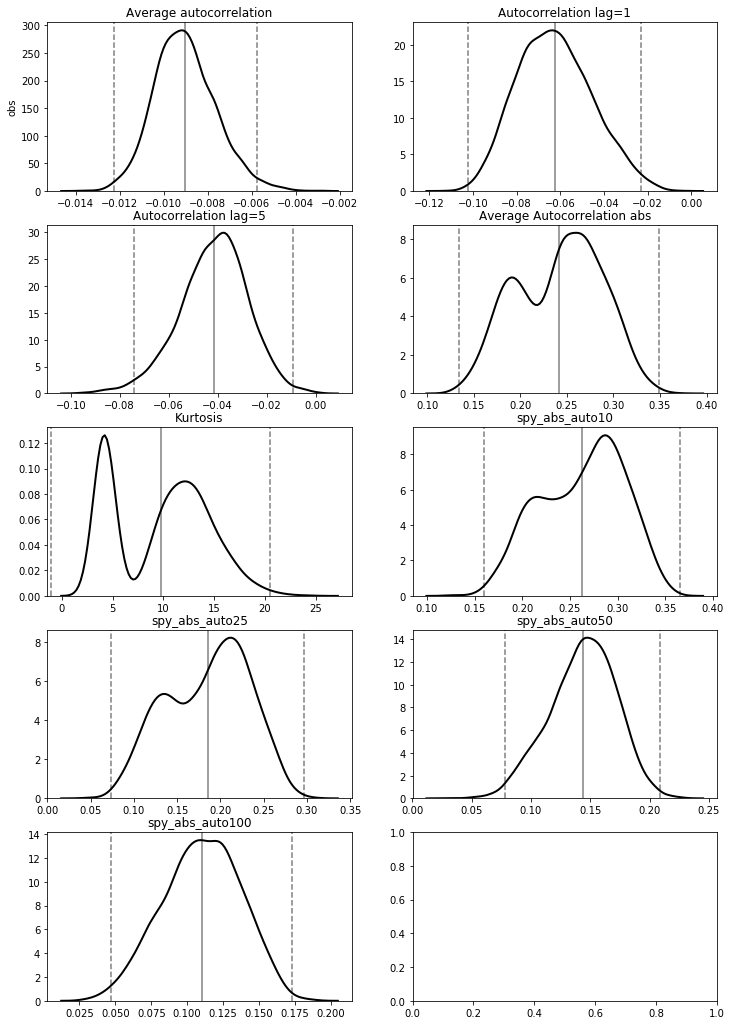

In [169]:
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6) , (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(12,18))

# 1 mean autocor
sns.distplot(first_order_autocors, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1)

for xc in confidence_interval(first_order_autocors):
    ax1.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax1.axvline(x=np.mean(first_order_autocors), color='k', alpha=0.5)

ax1.set_ylabel('obs')
ax1.set_title('Average autocorrelation')

# 2 autocorr lag 1 
sns.distplot(autocors1, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax2)
ax2.set_title('Autocorrelation lag=1')

for xc in confidence_interval(autocors1):
    ax2.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax2.axvline(x=np.mean(autocors1), color='k', alpha=0.5)

# 3 autocorr lag 1 
sns.distplot(autocors5, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax3)
ax3.set_title('Autocorrelation lag=5')

for xc in confidence_interval(autocors5):
    ax3.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax3.axvline(x=np.mean(autocors5), color='k', alpha=0.5)

# 4 mean abs autocor
sns.distplot(mean_abs_autocor, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax4)

for xc in confidence_interval(mean_abs_autocor):
    ax4.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax4.axvline(x=np.mean(mean_abs_autocor), color='k', alpha=0.5)
ax4.set_title('Average Autocorrelation abs')

# 5 kurtosis
sns.distplot(kurtoses, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax5)

for xc in confidence_interval(kurtoses):
    ax5.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax5.axvline(x=np.mean(kurtoses), color='k', alpha=0.5)
ax5.set_title('Kurtosis')

# 6 AC abs long 10
sns.distplot(spy_abs_auto10, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax6)

for xc in confidence_interval(spy_abs_auto10):
    ax6.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax6.axvline(x=np.mean(spy_abs_auto10), color='k', alpha=0.5)
ax6.set_title('spy_abs_auto10')

# 7 AC abs long 25
sns.distplot(spy_abs_auto25, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax7)

for xc in confidence_interval(spy_abs_auto25):
    ax7.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax7.axvline(x=np.mean(spy_abs_auto25), color='k', alpha=0.5)
ax7.set_title('spy_abs_auto25')

# 8 AC abs long 50
sns.distplot(spy_abs_auto50, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax8)

for xc in confidence_interval(spy_abs_auto50):
    ax8.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax8.axvline(x=np.mean(spy_abs_auto50), color='k', alpha=0.5)
ax8.set_title('spy_abs_auto50')

# 9 AC abs long 100
sns.distplot(spy_abs_auto100, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax9)

for xc in confidence_interval(spy_abs_auto100):
    ax9.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax9.axvline(x=np.mean(spy_abs_auto100), color='k', alpha=0.5)
ax9.set_title('spy_abs_auto100')

fig.savefig('moments.png')

and for **long memory**:
 
6. the autocorrelation function of vt ¼ at lag t ¼ 10
7. the autocorrelation function of vt ¼ at lag t 25,
8. the autocorrelation function of vt ¼ at lag t50; 
9. the autocorrelation function of vt ¼ at lag t 100.

Finally, for to measure the deviation from fundamentals, I use the 

In [30]:
spy_autocorrelation = autocorrelation_returns(spy_returns['price'], 25)
spy_autocorrelation1 = spy_returns['price'].autocorr(lag=1)
spy_autocorrelation5 = spy_returns['price'].autocorr(lag=5)
spy_kurtosis = kurtosis(spy_returns['price'])
spy_autocorrelation_abs = autocorrelation_abs_returns(spy_returns['price'], 25)
#spy_hurst = hurst(spy_all['price'])

# long memory:
spy_abs_auto10 = spy_returns['price'].abs().autocorr(lag=10)
spy_abs_auto25 = spy_returns['price'].abs().autocorr(lag=25)
spy_abs_auto50 = spy_returns['price'].abs().autocorr(lag=50)
spy_abs_auto100 = spy_returns['price'].abs().autocorr(lag=100)

#spy_dev_fund_hurst = hurst(spy_all['dev_fundamental'].iloc[:-1])
av_def_fund = abs(np.mean(spy_all['dev_fundamental']))
stylized_facts_spy = [spy_autocorrelation, spy_autocorrelation1, spy_autocorrelation5,
                      spy_kurtosis, spy_autocorrelation_abs, spy_abs_auto10, 
                      spy_abs_auto25, spy_abs_auto50, spy_abs_auto100, av_def_fund]

stylized_facts_spy = pd.DataFrame(stylized_facts_spy, columns=['S&P500'], 
             index=['autocorrelation', 'autocorrelation1', 'autocorrelation5',
                    'kurtosis', 'autocorrelation_abs', 'acf_abs10', 'acf_abs25',
                    'acf_abs50', 'acf_abs100', 'av_dev_from_fund']).to_dict()['S&P500']

In [31]:
stylized_facts_spy

{'acf_abs10': 0.072475104895203979,
 'acf_abs100': 0.022149454371627148,
 'acf_abs25': -0.042522722517340086,
 'acf_abs50': 0.01370050605199658,
 'autocorrelation': 0.00030320061625216735,
 'autocorrelation1': 0.24449426927505946,
 'autocorrelation5': 0.091815678384919108,
 'autocorrelation_abs': 0.049914003700974562,
 'av_dev_from_fund': 1.9880606822750695,
 'kurtosis': 3.0676490833426238}